# **`dm_control` TEST**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepmind/dm_control/blob/main/tutorial.ipynb)








# Imports

Run both of these cells:

In [1]:
#@title All `dm_control` imports required for this tutorial

# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

#@title Other imports and helper functions

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

## The *Control Suite*

The **Control Suite** is a set of stable, well-tested tasks designed to serve as a benchmark for continuous control learning agents. Tasks are written using the basic MuJoCo wrapper interface. Standardised action, observation and reward structures make suite-wide benchmarking simple and learning curves easy to interpret. Control Suite domains are not meant to be modified, in order to facilitate benchmarking. For full details regarding benchmarking, please refer to our original [publication](https://arxiv.org/abs/1801.00690).

A video of solved benchmark tasks is [available here](https://www.youtube.com/watch?v=rAai4QzcYbs&feature=youtu.be).

The suite come with convenient module level tuples for iterating over tasks:

## Example

In [ ]:
#@title Iterating over tasks{vertical-output: true}

max_len = max(len(d) for d, _ in suite.BENCHMARKING)
for domain, task in suite.BENCHMARKING:
  print(f'{domain:<{max_len}}  {task}')

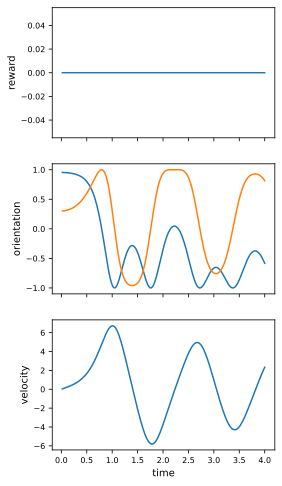

In [50]:
#@title Loading and simulating a `suite` task{vertical-output: true}
%matplotlib inline
import matplotlib.pyplot as plt

# Load the environment
random_state = np.random.RandomState(0)
env = suite.load('pendulum', 'swingup', task_kwargs={'random': random_state})

# Simulate episode with random actions
duration = 4  # Seconds
frames = []
ticks = []
rewards = []
observations = []

spec = env.action_spec()
time_step = env.reset()

while env.physics.data.time < duration:

  action = random_state.uniform(spec.maximum, spec.maximum, spec.shape)
  action = -spec.maximum * 100
  time_step = env.step(action)

  camera0 = env.physics.render(camera_id=0, height=200, width=200)
  camera1 = env.physics.render(camera_id=1, height=200, width=200)
  frames.append(np.hstack((camera0, camera1)))
  rewards.append(time_step.reward)
  observations.append(copy.deepcopy(time_step.observation))
  ticks.append(env.physics.data.time)

html_video = display_video(frames, framerate=1./env.control_timestep())

# Show video and plot reward and observations
num_sensors = len(time_step.observation)

_, ax = plt.subplots(1 + num_sensors, 1, sharex=True, figsize=(4, 8))
ax[0].plot(ticks, rewards)
ax[0].set_ylabel('reward')
ax[-1].set_xlabel('time')

for i, key in enumerate(time_step.observation):
  data = np.asarray([observations[j][key] for j in range(len(observations))])
  ax[i+1].plot(ticks, data, label=key)
  ax[i+1].set_ylabel(key)


html_video


## USE

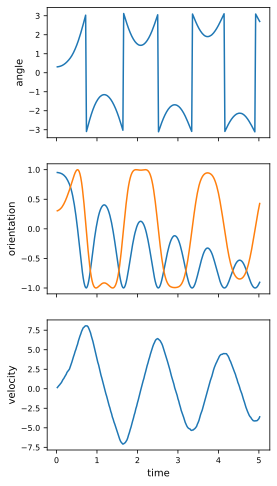

In [29]:
#@title Loading and simulating a `suite` task{vertical-output: true}
%matplotlib inline
import matplotlib.pyplot as plt
import math

# Load the environment
random_state = np.random.RandomState(0)
env = suite.load('pendulum', 'swingup', task_kwargs={'random': random_state})

# Simulate episode with random actions
duration = 5 # Seconds
frames = []
ticks = []
rewards = []
observations = []
angle = []
action_list = []

spec = env.action_spec()
time_step = env.reset()


while env.physics.data.time < duration:
  action = random_state.uniform(spec.minimum, spec.maximum, spec.shape)
  action_list.append(action)
  time_step = env.step(action)
  rewards.append(time_step.reward)
  temp = copy.deepcopy(time_step.observation)
  observations.append(temp)
  ticks.append(env.physics.data.time)
  # angle.append([math.atan2(temp['orientation'][1],temp['orientation'][0]) % (2*math.pi)])
  angle.append([math.atan2(temp['orientation'][1],temp['orientation'][0])])

# Show video and plot reward and observations
num_sensors = len(time_step.observation)

_, ax = plt.subplots(num_sensors + 1, 1, sharex=True, figsize=(4, 8))

ax[0].plot(ticks, angle)
ax[0].set_ylabel('angle')
ax[-1].set_xlabel('time')

for i, key in enumerate(time_step.observation):
  data = np.asarray([observations[j][key] for j in range(len(observations))])
  ax[i+1].plot(ticks, data, label=key)
  ax[i+1].set_ylabel(key)


## Collect Data

In [18]:
# DeePC
n_sim = len(observations)
p = 2
m = 1
yData = np.empty((p,n_sim)) # angle, angle_dot
uData = np.empty((m,n_sim)) # torque
for t in range(n_sim):    
    yData[:,[t]] = np.stack((np.array(angle[t]), observations[t]['velocity']))
    uData[:,[t]] = action_list[t]    


## Create Controller

In [38]:
from deepc import DeePC
# set parameters
params = {}
params['uData'] = uData
params['yData'] = yData
params['N'] = 10
params['Q'] = np.array([[100,0],[0,10]])#np.eye(2)
params['R'] = np.eye(1)*0.01
params['lambda_slack'] = 10**3#10**3# 10**7
params['lambda_g'] = 300#300# 100

# create controller    
controller = DeePC(params)
# controller.create_Hankel_check()

# offline computation
controller.create_Hankel_check()      
controller.create_Hankel()  



14
(14, 238)
We are good to go!!
(36, 240)
36


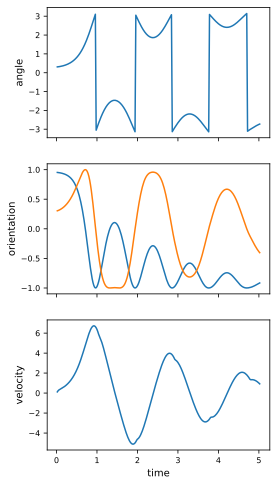

In [51]:
# Load the environment
random_state = np.random.RandomState(0)
env = suite.load('pendulum', 'swingup', task_kwargs={'random': random_state})

# Simulate episode with random actions
duration = 5 # Seconds
frames = []
ticks = []
rewards = []
observations = []
angle = []
action_list = []
frames = []

spec = env.action_spec()
time_step = env.reset()
count_ini = 0

# ---- DeePC ----
T_ini = p
u_ini = np.empty((m*T_ini,1)) # angle, angle_dot
y_ini = np.empty((p*T_ini,1)) # torque


while env.physics.data.time < duration: 
  if count_ini < 2:
        action = [0]
  else:
        action = controller.computeInput(u_ini,y_ini)
  action_list.append(action)
  time_step = env.step(action)
  rewards.append(time_step.reward)
  temp = copy.deepcopy(time_step.observation)
  observations.append(temp)
  ticks.append(env.physics.data.time)
  angle_temp = [math.atan2(temp['orientation'][1],temp['orientation'][0])]
#   angle_temp = [math.atan2(temp['orientation'][1],temp['orientation'][0]) % (2*math.pi)]
  angle.append(angle_temp)
  u = np.array(action)
  y = np.stack((np.array(angle_temp), observations[0]['velocity']))

  if count_ini < 2:
        u_ini[count_ini*T_ini:(count_ini+1)*T_ini] = u
        y_ini[count_ini*T_ini:(count_ini+1)*T_ini] = y
  else:
        u_ini = np.block([[u_ini[T_ini:]],[u]])
        y_ini = np.block([[y_ini[T_ini:]],[y]])
  count_ini += 1
      
  camera0 = env.physics.render(camera_id=0, height=200, width=200)
  camera1 = env.physics.render(camera_id=1, height=200, width=200)
  frames.append(np.hstack((camera0, camera1)))
  
html_video = display_video(frames, framerate=1./env.control_timestep())

# Show video and plot reward and observations
num_sensors = len(time_step.observation)

_, ax = plt.subplots(num_sensors + 1, 1, sharex=True, figsize=(4, 8))

ax[0].plot(ticks, angle)
ax[0].set_ylabel('angle')
ax[-1].set_xlabel('time')

for i, key in enumerate(time_step.observation):
  data = np.asarray([observations[j][key] for j in range(len(observations))])
  ax[i+1].plot(ticks, data, label=key)
  ax[i+1].set_ylabel(key)


html_video


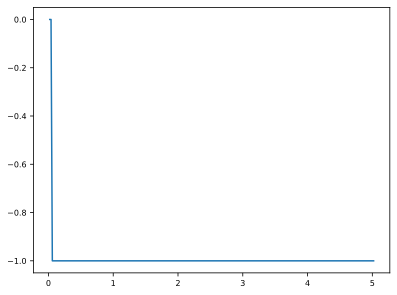

In [45]:
plt.plot(ticks, action_list)